In [1]:
## classify as either 0 to 3 or 4 to 8

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
DATA_ROOT = "../../fiot_highway2-main/data/"
TRAIN_TXT = "../../fiot_highway2-main/train.txt"
TEST_TXT  = "../../fiot_highway2-main/test.txt"
MIN_LABEL = 0
MAX_LABEL = 8
RESIZE_TO = (64, 64)
BATCH_SIZE = 32
LR = 1e-3
MAX_EPOCHS = 8
MIN_DB = -140.0 #WARNING: based on visualzing dataset may not be the absolute min
MAX_DB =   0.0
BINARY_CLASS_DIV = 2

def struct_extract(struct, min_label, max_label):
    paths  = []
    labels = []
    for entry in struct:
        label = int(entry[1])
        if min_label <= label <= max_label:
            path = entry[0].split('/')[1].split('.')[0]
            paths.append(path)
            labels.append(label)
    return paths, labels

all_train_struct = np.loadtxt(TRAIN_TXT, dtype=str).tolist()
all_test_struct  = np.loadtxt(TEST_TXT,  dtype=str).tolist()

def boosted_struct_extract(boosted_folder, target_label=3):
    files = [f for f in os.listdir(boosted_folder) if f.endswith('.npy')]
    paths = [os.path.splitext(f)[0] for f in files]
    labels = [target_label] * len(paths)
    return paths, labels

train_paths, train_labels = struct_extract(all_train_struct, MIN_LABEL, MAX_LABEL)
test_paths,  test_labels  = struct_extract(all_test_struct,  MIN_LABEL, MAX_LABEL)
boosted3_paths, boosted3_labels = boosted_struct_extract("./BoostedClass3", target_label=3)
boosted4_paths, boosted4_labels = boosted_struct_extract("./BoostedClass4", target_label=4)
boosted5_paths, boosted5_labels = boosted_struct_extract("./BoostedClass5", target_label=5)
boosted6_paths, boosted6_labels = boosted_struct_extract("./BoostedClass6", target_label=6)
boosted7_paths, boosted7_labels = boosted_struct_extract("./BoostedClass7", target_label=7)
boosted8_paths, boosted8_labels = boosted_struct_extract("./BoostedClass8", target_label=8)
print(len(train_labels))
print(len(boosted3_paths))
print("done")

class HighwayDataset(Dataset):
    def __init__(self, paths, labels, data_root, resize=(64,64)):
        self.paths = paths
        self.labels = labels
        self.data_root = data_root
        self.resize = resize

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        fname = self.paths[idx] + ".npy"
        arr = np.load(os.path.join(self.data_root, fname))   # shape (512,243)
        arr = np.clip(arr, MIN_DB, MAX_DB) # Clip to a fixed dB range 
        arr = (arr - MIN_DB) / (MAX_DB - MIN_DB) # Scale to [0,1] VERIFY THIS
        img = torch.from_numpy(arr.astype(np.float32))    # H x W
        img = img.unsqueeze(0)                            # 1 Input Channel (amplitude) || 1 x H x W
        img = TF.resize(img, self.resize)                 # RESIZE still 1 x h x w

        if self.labels[idx] <= BINARY_CLASS_DIV:
            label = 0
        else:
            label = 1
        return img, label

train_ds = HighwayDataset(train_paths, train_labels, DATA_ROOT, RESIZE_TO)
test_ds  = HighwayDataset(test_paths,  test_labels, DATA_ROOT, RESIZE_TO)

boosted_class3_train_ds = HighwayDataset(boosted3_paths, boosted3_labels, "./BoostedClass3", RESIZE_TO)
boosted_class4_train_ds = HighwayDataset(boosted4_paths, boosted4_labels, "./BoostedClass4", RESIZE_TO)
boosted_class5_train_ds = HighwayDataset(boosted5_paths, boosted5_labels, "./BoostedClass5", RESIZE_TO)
boosted_class6_train_ds = HighwayDataset(boosted6_paths, boosted6_labels, "./BoostedClass6", RESIZE_TO)
boosted_class7_train_ds = HighwayDataset(boosted7_paths, boosted7_labels, "./BoostedClass7", RESIZE_TO)
boosted_class8_train_ds = HighwayDataset(boosted8_paths, boosted8_labels, "./BoostedClass8", RESIZE_TO)

# merged_train_ds = ConcatDataset([train_ds, boosted_class3_train_ds, boosted_class4_train_ds, boosted_class5_train_ds, boosted_class6_train_ds, boosted_class7_train_ds, boosted_class8_train_ds])
merged_train_ds = ConcatDataset([train_ds, boosted_class3_train_ds])

train_loader = DataLoader(merged_train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4) #best number workers depends on CPU cores
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, num_workers=4) #best number workers depends on CPU cores
print("done")

12915
500
done
done


In [ ]:
class CNN(pl.LightningModule):
    def __init__(self, num_classes=2):
        super().__init__()
        self.save_hyperparameters()
        ## WARNING: this assumes the size is 64x64, not generalized for different cases yet.
        
        ## Model:
        ## 1st Convolution, ReLu, Pooling Block
        # Convolution: (1 = input channels, 16 = output channels, kernal_size = 3x3, padding = 1 keeps spatial size the same (Shape 1x64x64 -> 16x64x64), 
        # ReLU
        # Pooling: downsamples (16x64x64 -> 16x32x32)
        ## 2nd Convolution ReLu, Pooling Block
        # Convolution: (16, 32, 32) → (32, 32, 32)
        # ReLU:
        # Pooling: (32, 32, 32) → (32, 16, 16)
        ## 3rd Convolution ReLu, Pooling Block
        # Convolution: (32, 16, 16) → (64, 16, 16)
        # ReLU:
        # Pooling: (64, 16, 16) → (64, 8, 8)
        ## Flatten: (64, 8, 8) -> single vector length 4096
        ## Linear: fully connected layers compresses 4096 learned features into 128
        # ReLU:
        ## Linear: compresses 128 into num_classes | creates logits
        
        # ##reduced stride slighlty
        # self.model = nn.Sequential(
        #     nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
        
        #     nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
        #     nn.MaxPool2d(2),   # 64 → 32
        
        #     nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        #     nn.MaxPool2d(2),   # 32 → 16
        
        #     nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        
        #     nn.Flatten(),
        #     nn.Linear(128 * 16 * 16, 128), nn.ReLU(),
        #     nn.Linear(128, num_classes)
        # )

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), 
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.loss_fn = nn.CrossEntropyLoss() #applies softmax to logits

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LR)
print("done")
logger = CSVLogger("logs", name="cnn_highway")

model = CNN()
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    logger=logger,
    accelerator="auto"
)
trainer.fit(model, train_loader) #train
trainer.test(model, test_loader) #test
print("done")

done


/usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 547 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
547 K     Trainable params
0         Non-trainable params
547 K     Total params
2.192     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9648058414459229     │
│         test_loss         │    0.11702361702919006    │
└───────────────────────────┴───────────────────────────┘

done


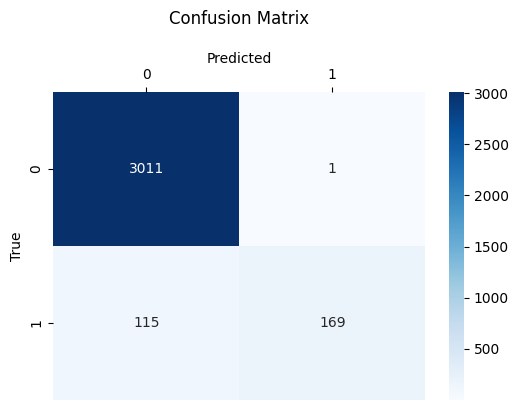

done


In [ ]:
y_true = []
y_pred = []
model.eval() #put model in output mode
with torch.no_grad(): #saves memory as no gradients stored?
    for x, y in test_loader:
        logits = model(x) #runs the model with the input x, to get raw predicitons (running the forward step in CNN)
        preds = logits.argmax(1) #preds gets model predicitons from raw logits
        y_true.extend(y.cpu().numpy()) #y has the know true labels
        y_pred.extend(preds.cpu().numpy()) 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(range(0,2)),
            yticklabels=list(range(0,2)))

plt.gca().xaxis.set_label_position('top')  # put x-label on top
plt.gca().xaxis.tick_top()                 # put x-ticks on top

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix", pad=20)
plt.show()
print("done")

In [6]:
# Collect results per original class
class_stats = {c: {"pred_bin_0": 0, "pred_bin_1": 0} for c in range(9)}

# true labels from test dataset BEFORE binary conversion
orig_true_labels = test_labels  

# Iterate through true labels and predicted binary labels
for true_label, pred_bin in zip(orig_true_labels, y_pred):
    if pred_bin == 0:
        class_stats[true_label]["pred_bin_0"] += 1
    else:
        class_stats[true_label]["pred_bin_1"] += 1

# Print results
print("===== Per-Class Binary Prediction Breakdown =====")
print("OriginalClass | Predicted as 0 (0–2) | Predicted as 1 (3–8)")
print("-----------------------------------------------------------")
for c in range(9):
    print(f"      {c}       |        {class_stats[c]['pred_bin_0']:4d}        |        {class_stats[c]['pred_bin_1']:4d}")

===== Per-Class Binary Prediction Breakdown =====
OriginalClass | Predicted as 0 (0–2) | Predicted as 1 (3–8)
-----------------------------------------------------------
      0       |        1048        |           0
      1       |         576        |           0
      2       |        1387        |           1
      3       |          12        |           0
      4       |          23        |          21
      5       |           2        |          70
      6       |          27        |          57
      7       |          19        |          21
      8       |          32        |           0


Latest version folder: logs/cnn_highway/version_35
Loading metrics from: logs/cnn_highway/version_35/metrics.csv


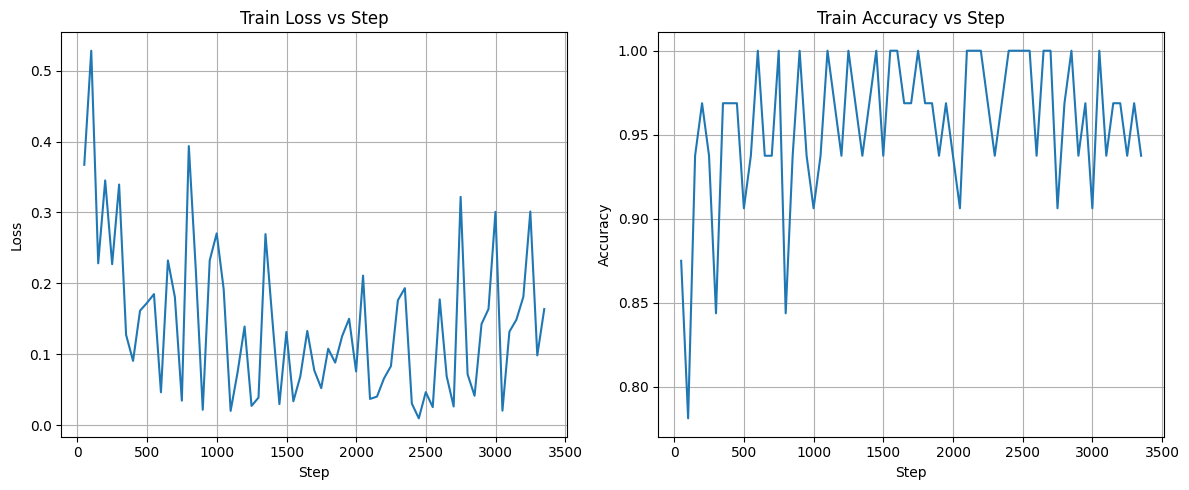

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

log_dir = "logs/cnn_highway"

# Sort numerically instead of lexicographically
versions = sorted(
    glob.glob(os.path.join(log_dir, "version_*")),
    key=lambda x: int(os.path.basename(x).split("_")[1])
)
if len(versions) == 0:
    raise RuntimeError("No version_x folders found in logs directory!")

latest = versions[-1]
print("Latest version folder:", latest)

metrics_file = os.path.join(latest, "metrics.csv")
print("Loading metrics from:", metrics_file)

df = pd.read_csv(metrics_file)

train_loss = df[["step", "train_loss"]].dropna()
train_acc  = df[["step", "train_acc"]].dropna()

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_loss["step"], train_loss["train_loss"])
plt.title("Train Loss vs Step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc["step"], train_acc["train_acc"])
plt.title("Train Accuracy vs Step")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()